In [1]:
#!/usr/bin/env python
import math
import random
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2
import re

from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend

PATH_PICS_FOLDER = "/home/fizzer/353comp/src/imitation_pics/"
SUPPLEMENTARY_PIC_FOLDER = "/home/fizzer/353comp/src/imitation_pics/supplementary/"

def pic_file_list(folder_path):
    pic_path_list = []

    for r,d,f in os.walk(folder_path):
        for file in f:
            if '.png' in file:
                filePath = os.path.join(r,file)
                pic_path_list.append(filePath)

    return pic_path_list

backward_pic_list = pic_file_list(PATH_PICS_FOLDER + "backward")
forward_pic_list = pic_file_list(PATH_PICS_FOLDER + "forward")
left_pic_list = pic_file_list(PATH_PICS_FOLDER + "left")
right_pic_list = pic_file_list(PATH_PICS_FOLDER + "right")


sup_forward_pic_list = pic_file_list(SUPPLEMENTARY_PIC_FOLDER + "sup_forward")
sup_left_pic_list = pic_file_list(SUPPLEMENTARY_PIC_FOLDER + "sup_left")
sup_right_pic_list = pic_file_list(SUPPLEMENTARY_PIC_FOLDER + "sup_right")

#print("Number of images loaded:  {:}".format(len(total_pic_list)))

Using TensorFlow backend.


In [2]:
#Choose what to train here
random.shuffle(backward_pic_list)
random.shuffle(forward_pic_list)
random.shuffle(left_pic_list)
random.shuffle(right_pic_list)

random.shuffle(sup_forward_pic_list)
random.shuffle(sup_left_pic_list)
random.shuffle(sup_right_pic_list
)
PICS_TO_USE = 250

training_pic_list = []
sup_training_pic_list = []

training_pic_list.extend(backward_pic_list[:PICS_TO_USE] + right_pic_list[:PICS_TO_USE] + left_pic_list[:PICS_TO_USE] + forward_pic_list[:PICS_TO_USE])
sup_training_pic_list.extend(sup_forward_pic_list + sup_left_pic_list + sup_right_pic_list[:5000])

total_train_list = []
total_train_list.extend(sup_training_pic_list + training_pic_list)

random.shuffle(total_train_list)
X_train = []
Y_train = []


for img in total_train_list:

    frame_pic = cv2.imread(img)
    X_train.append(frame_pic)

    if img in forward_pic_list or img in sup_forward_pic_list:
        Y_train.append([1,0,0,0])
    elif img in backward_pic_list:
         Y_train.append([0,1,0,0])
    elif img in left_pic_list or img in sup_left_pic_list:
         Y_train.append([0,0,1,0])
    elif img in right_pic_list or img in sup_right_pic_list:
         Y_train.append([0,0,0,1])
         

#Normalize
X_train = np.array(X_train)
X_train_normed = X_train / 255
Y_train = np.array(Y_train)

print(len(total_train_list))

9413


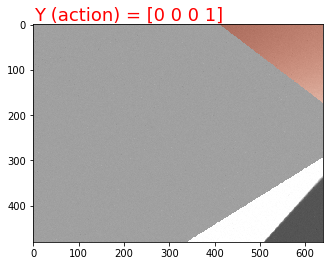

In [10]:
def display_image(index):
    plt.imshow(X_train[index])
    caption = ("Y (action) = " + str(Y_train[index]))
    plt.text(0.5,0.5,caption, color = 'red', fontsize=18, horizontalalignment='left', verticalalignment ='bottom')

display_image(9500)

In [4]:
model = models.load_model("/home/fizzer/Comp_CNN/please.h5")
model._make_predict_function()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.RMSprop(lr=1e-4),
                  metrics=['accuracy'])

Train on 7059 samples, validate on 2354 samples
Epoch 1/4
7059/7059 [==============================] - 2169s 307ms/step - loss: 0.1455 - acc: 0.9473 - val_loss: 0.1285 - val_acc: 0.9605
Epoch 2/4
7059/7059 [==============================] - 1673s 237ms/step - loss: 0.1217 - acc: 0.9572 - val_loss: 0.1401 - val_acc: 0.9592
Epoch 3/4
7059/7059 [==============================] - 1656s 235ms/step - loss: 0.1058 - acc: 0.9622 - val_loss: 0.1085 - val_acc: 0.9601
Epoch 4/4
7059/7059 [==============================] - 1869s 265ms/step - loss: 0.0968 - acc: 0.9657 - val_loss: 0.1386 - val_acc: 0.9601


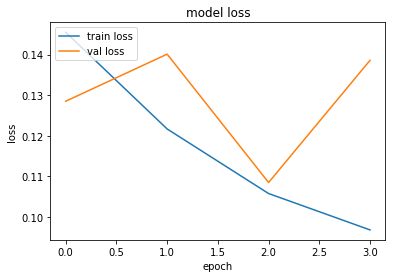

In [6]:
VALIDATION_SPLIT = 0.25
history_conv = model.fit(X_train_normed,Y_train,
                              batch_size=32,
                              epochs=4,
                              validation_split=VALIDATION_SPLIT)
#plot loss vs epoch
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

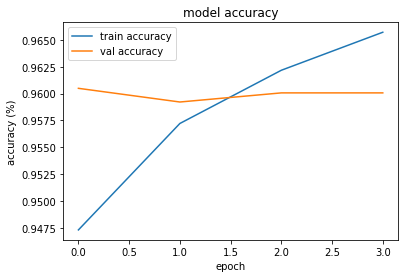

In [7]:
#plot accuracy % vs epoch
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
def displayResult(index):
    img = X_train_normed[index]
    img_with_top = np.expand_dims(img,axis=0)
    
    y_predict = model.predict(img_with_top)
    print y_predict
        
    plt.imshow(X_train[index])

    caption = ("Actual: {}\nPredicted: {}".
                format(Y_train[index], y_predict))
    plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')
    
    return y_predict

displayResult(90)

In [8]:
model.save("more_please.h5")
print("saved model")

#Note: to load module use load_model(filepath)

saved model


In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
split = int(round(len(X_train))*(1-VALIDATION_SPLIT))
print split

labels = ["Forward", "Backward", "Left", "Right"]
y_gnd_truth = Y_train[split:].argmax(axis=1)
y_pred_raw = model.predict(X_train_normed[split:])
y_pred = y_pred_raw.argmax(axis=1)

matrix = metrics.confusion_matrix(y_gnd_truth, y_pred)

df_cm = pd.DataFrame(matrix, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
#plt.matshow(matrix)